In [10]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import minimize, root, curve_fit
import pylab as pl
%matplotlib inline

In [11]:
# Data from the peng paper
data = np.loadtxt('peng.txt', delimiter=',')

In [12]:
# Picking the data before re-injection of solute:
t_data = data.T[0][:11]
r_data = data.T[1][:11]
# Generating the fitted curve from data by interpolation:
r_fit = interp1d(t_data, r_data, kind = 'slinear')

In [13]:
lcap = 6e-9
# Taking the value from fit at t = 0:
R0   = r_fit(0) * 1e-9
cinf = 55.33
cs   = 5.53e-2
Vm   = 3.29e-5

In [14]:
def dR_dt(R, t, beta, Da, delta_C):
    dRdt = (cinf - beta * R**3 - cs * np.exp(lcap / (R0 * R)))/(delta_C * (Da + R))
    return dRdt

In [15]:
def fit_parameters_minimize(x):
    D  = x[0]
    k  = x[1]
    cs = x[2]
    N0 = x[3]
    
    beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
    Da      = D/(k*R0)
    delta_C = cinf - cs * np.exp(lcap/R0)
    t0      = R0**2 / (Vm * D * delta_C)
    
    t   = np.linspace(0, t_data[-1], 1000)
    sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)

    return(np.mean((sol.ravel() * R0 / 1e-9 - r_fit(t))**2))

In [27]:
guess = np.array([1e-18, 1e-10, 1e-2, 1e21])
guess2 = np.array([3.01e-18, 7.97e-10, 5.53e-2, 8.04e21])
bnds  = ((1e-19, 1e-17), (1e-11, 1e-9), (1e-4, 1e-2), (1e20, 1e22))
sol   = minimize(fit_parameters_minimize, guess, bounds = bnds)

print(fit_parameters_minimize(sol.x))
print(fit_parameters_minimize(guess2))

0.051414864061792305
0.0023041818060397846


In [28]:
sol.x

array([1.e-18, 1.e-10, 1.e-02, 1.e+21])

In [49]:
def fit_parameters_root(x):
    D  = abs(x[0])
    k  = abs(x[1])
    cs = abs(x[2])
    N0 = abs(x[3])
    
    bnds = ((1e-19, 1e-17), (1e-11, 1e-9), (1e-4, 1e-2), (1e20, 1e22))
    if(D > 1e-17 or D < 1e-19):
        return(100000 * np.ones(1000))
    if(k > 1e-9 or k < 1e-11):
        return(100000 * np.ones(1000))
    if(cs > 1e-1 or cs < 1e-3):
        return(100000 * np.ones(1000))
    if(N0 > 1e22 or N0 < 1e20):
        return(100000 * np.ones(1000))
    
        
    beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
    Da      = D/(k*R0)
    delta_C = cinf - cs * np.exp(lcap/R0)
    t0      = R0**2 / (Vm * D * delta_C)
    
    t   = np.linspace(0, t_data[-1], 1000)
    sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)
    
#     pl.plot(t, sol.ravel() * R0 / 1e-9)
#     pl.plot(t, r_fit(t), 'k--')
#     pl.show()
    
    return((sol.ravel() * R0 / 1e-9 - r_fit(t))**2)

In [55]:
guess = np.array([3e-18, 8e-10, 5e-2, 8e21])
sol   = root(fit_parameters_root, guess, method = 'lm')

In [56]:
print(np.sum(fit_parameters_root(sol.x)))
print(np.sum(fit_parameters_root(np.array([3.01e-18, 7.97e-10, 5.53e-2, 8.04e21]))))

2.4021903289124307
2.3041818060397845


In [57]:
D  = sol.x[0]
k  = sol.x[1]
cs = sol.x[2]
N0 = sol.x[3]

beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
Da      = D/(k*R0)
delta_C = cinf - cs * np.exp(lcap/R0)
t0      = R0**2 / (Vm * D * delta_C)

sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)

NameError: name 't' is not defined

Text(0, 0.5, '$R$(in nm)')

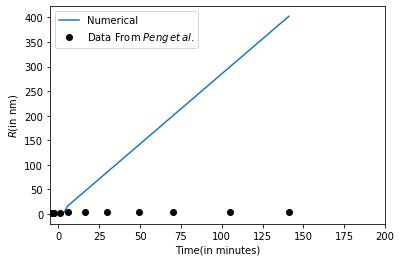

In [241]:
t = np.linspace(0, t_data[-1], 50)
pl.plot(t, sol * R0 / 1e-9, label = 'Numerical')
pl.plot(t_data, r_data, 'ko', label = r'Data From $\it{Peng\,et\,al.}$')
pl.xlim(-5, 200)
pl.legend()
pl.xlabel('Time(in minutes)')
pl.ylabel(r'$R$(in nm)')

In [83]:
def fit_parameters_curvefit(t, D, k, cs, N0):
#     if(D > 10 or D < 0.1):
#         return(100000 * np.ones(50))
#     if(k > 10 or k < 0.1):
#         return(100000 * np.ones(50))
#     if(cs > 10 or cs < 0.1):
#         return(100000 * np.ones(50))
#     if(N0 > 10 or N0 < 0.1):
#         return(100000 * np.ones(50))

    D  = D  * 1e-18
    k  = k  * 1e-10
    cs = cs * 1e-3
    N0 = N0 * 1e21
    
    beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
    Da      = D/(k*R0)
    delta_C = cinf - cs * np.exp(lcap/R0)
    t0      = R0**2 / (Vm * D * delta_C)
    
    sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)
    return(sol.ravel() * R0 / 1e-9)

In [84]:
t = np.linspace(0, t_data[-1], 50)
# bnds  = ((0.1, 10), (0.1, 10), (0.1, 10), (0.1, 10))
popt, pcov = curve_fit(fit_parameters_curvefit, t, r_fit(t), bounds = (1, 10))

In [85]:
# pl.plot(t * t0 / 60, sol1 * R0 / 1e-9, label = 'Numerical')
# pl.plot(data.T[0], data.T[1], 'ko', label = r'Data From $\it{Peng\,et\,al.}$')
# pl.xlim(-5, 200)
# pl.legend()
# pl.xlabel('Time(in minutes)')
# pl.ylabel(r'$R$(in nm)')

In [86]:
popt * np.array([1e-18, 1e-10, 1e-2, 1e21])

array([2.39546803e-18, 1.00000000e-09, 3.65970469e-02, 8.13663552e+21])

In [87]:
np.array([3.01e-18, 7.97e-10, 5.53e-2, 8.04e21])

array([3.01e-18, 7.97e-10, 5.53e-02, 8.04e+21])

In [88]:
curve_fit?

In [89]:
fit_parameters_minimize(np.array([3.01e-18, 7.97e-10, 5.53e-2, 8.04e21]))

0.002424226143264079

In [90]:
fit_parameters_minimize(popt * np.array([1e-18, 1e-10, 1e-2, 1e21]))

0.0021624544289396233